# AdaBoosting

In [1]:
from preprocessing import *
from aux import *
import matplotlib
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado 1

In [2]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [3]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [4]:
volver = ['volveria']
columnas = columnillas + volver

In [5]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2,1.0


In [6]:
df.shape

(801, 15)

## Entrenamiento

In [7]:
X, y = split_dataset_X_y(df, columnillas)
model_ada = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(
        max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state=117)

best_params, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, model_ada, ADA_PARAMS)

ada_boosting = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117,criterion="entropy"),
    random_state=117,
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    algorithm = best_params['algorithm']
)
ada = apply_stratified_k_fold(X, y, ada_boosting)

X.shape:  (801, 14)
y.shape:  (801,) 

Best score: 0.8562371030567018
Best params {'n_estimators': 47, 'learning_rate': 0.1, 'algorithm': 'SAMME'}

Fold 0: AUC ROC score is 0.7610
Fold 1: AUC ROC score is 0.7931
Fold 2: AUC ROC score is 0.8581
Fold 3: AUC ROC score is 0.7995
Fold 4: AUC ROC score is 0.8000
Mean test AUC ROC is: 0.8023


## Métricas

In [8]:
scores = get_scores(ada, X_test, y_test)

AUC ROC : 0.9109
Accuracy : 0.8756
Precision : 0.8889
Recall : 0.9449
F1-Score : 0.8175


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


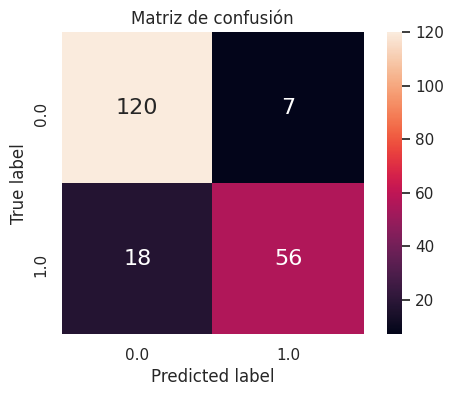

In [9]:
plot_confusion_matrix(y_test, ada.predict(X_test))

## Test Holdout

In [10]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [11]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,1,0,0,0.0


In [12]:
df_resultado = evaluate_holdout(holdout, df_h, ada)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [13]:
df_resultado.to_csv('prediccion/Ada_boosting_resultado_final.csv')

## Preprocesado 2

In [45]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = replace_nulls_column(df, 'edad', 'mediana')
    df = eliminar_feature(df, 'amigos')
    df = eliminar_feature(df, 'parientes')
    df = normalizar_atributos_numericos(df)
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [46]:
columnas_2 = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              ]

In [47]:
df_2 = preprocesado_2(dataset, columnas_2+volver)

df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000000,0,1,0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.020408,0,1,0,0.0
2,0,1,0,0.891011,0,0,0.346734,0.040816,0,0,0,0.0
3,1,0,0,0.510112,0,0,0.346734,0.000000,1,0,0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.020408,1,0,0,1.0


In [48]:
df_2.shape

(801, 12)

## Entrenamiento

In [49]:
X_2, y_2 = split_dataset_X_y(df_2, columnas_2)
model_ada_2 = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(
        max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state=117)

best_params_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, model_ada_2, 
                                                                                        ADA_PARAMS)

ada_boosting_2 = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117,criterion="entropy"),
    random_state=117,
    n_estimators = best_params_2['n_estimators'],
    learning_rate = best_params_2['learning_rate'],
    algorithm = best_params_2['algorithm']
)
ada_2 = apply_stratified_k_fold(X_2, y_2, ada_boosting_2)

X.shape:  (801, 11)
y.shape:  (801,) 

Best score: 0.854220033968301
Best params {'n_estimators': 35, 'learning_rate': 0.2, 'algorithm': 'SAMME'}

Fold 0: AUC ROC score is 0.7458
Fold 1: AUC ROC score is 0.7761
Fold 2: AUC ROC score is 0.8335
Fold 3: AUC ROC score is 0.7925
Fold 4: AUC ROC score is 0.7928
Mean test AUC ROC is: 0.7882


## Métricas

In [50]:
scores_2 = get_scores(ada_2, X_test_2, y_test_2)

AUC ROC : 0.9088
Accuracy : 0.8607
Precision : 0.8485
Recall : 0.9213
F1-Score : 0.8000


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


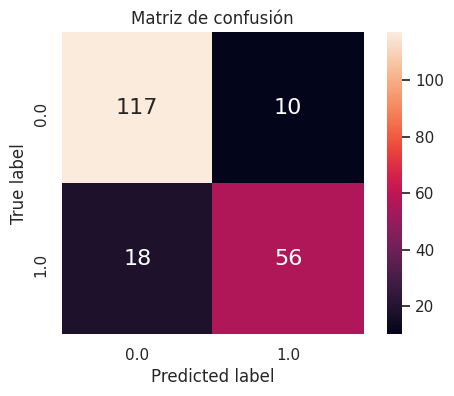

In [51]:
plot_confusion_matrix(y_test_2, ada_2.predict(X_test_2))

## Test Holdout #2

In [52]:
df_h_2 = preprocesado_2(holdout, columnas_2)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,0.751756,1,0,0.344774,0.000000,1,0,0
1,1,0,0,0.264637,1,0,0.063963,0.061224,1,0,0
2,0,1,0,0.026932,0,0,0.609984,0.040816,0,0,0
3,0,0,0,0.637002,0,0,0.407176,0.040816,1,0,0
4,1,0,0,0.471897,0,0,0.438378,0.000000,1,0,0


In [53]:
df_resultado_2 = evaluate_holdout(holdout, df_h_2, ada_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 11) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [54]:
df_resultado_2.to_csv('prediccion/Ada_boosting_2do_prepoc_resultado_final.csv')